# Class imbalance and invalid metric selection

In this notebook we give an example when a highly imbalanced data and invalid metric selection can give a misleading representation about the model quality.

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import DatasetIndex, Pipeline, B, V
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel

from src import show_loss

## Dataset

For training and model performance assessment we use the MNIST dataset of images of size 28х28 pixels in greyscale.

In [2]:
mnist = MNIST()

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


Let's add class imbalance by reducing the number of digits 7, 8 and 9 by 500 times:

In [3]:
def downsample_classes(dataset, targets, classes, factor):
    unique_classes = np.unique(targets)
    indices = []
    for cls in unique_classes:
        cls_indices = dataset.indices[targets == cls]
        if cls in classes:
            cls_indices = np.random.choice(cls_indices, len(cls_indices) // factor, replace=False)
        indices.append(cls_indices)
    index = DatasetIndex(np.sort(np.concatenate(indices)))
    return dataset.create_subset(index)

In [4]:
CLASSES = [7, 8, 9]
FACTOR = 500

mnist.train = downsample_classes(mnist.train, mnist.train.preloaded[1], CLASSES, FACTOR)
mnist.test = downsample_classes(mnist.test, mnist.test.preloaded[1], CLASSES, FACTOR)

## Model architecture

We use CNN with 3 convolutional layers and one dense layer in the end.

Loss function is categorical cross-entropy.

Optimizer is Adam with default parameters.

In [5]:
model_config = {
    "inputs": dict(images={"shape": B("image_shape")},
                   labels={"classes": 10}),
    "initial_block/inputs": "images",
    "body": {"layout": "cpa" * 3, "filters": 10, "kernel_size": 3},
    "head": {"layout": "f", "units": 10},
    "loss": "crossentropy",
    "optimizer": "Adam",
}

## Model training

We train model for 10 epochs with batch size 256.

In [6]:
N_EPOCH = 10
BATCH_SIZE = 256

In [7]:
template_train_pipeline = (
    Pipeline()
    .init_variable("loss_history", init_on_each_run=list)
    .init_model("dynamic", TFModel, "conv_model", config=model_config)
    .to_array()
    .train_model("conv_model", images=B("images"), labels=B("labels"),
                 fetches="loss", save_to=V("loss_history"), mode="a")
    .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True, bar=True, lazy=True)
)

train_pipeline = (mnist.train >> template_train_pipeline).run()

100%|██████████| 1630/1630 [05:16<00:00,  5.43it/s]


Loss function vs number of iterations plot comes to a plateau, which indicates the convergence of the learning process:

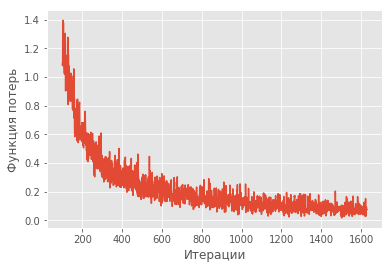

In [8]:
show_loss(train_pipeline.get_variable("loss_history"), skip=100)

## Model evaluation and model criticism

First, let's look at the accuracy metric on the test dataset:

In [9]:
template_test_pipeline = (
    Pipeline()
    .import_model("conv_model", train_pipeline)
    .init_variable("predictions")
    .init_variable("metrics", init_on_each_run=None)
    .to_array()
    .predict_model("conv_model", images=B("images"), labels=B("labels"),
                   fetches="predictions", save_to=V("predictions"))
    .gather_metrics("class", targets=B("labels"), predictions=V("predictions"),
                    fmt="logits", axis=-1, save_to=V("metrics"), mode="u")
    .run(batch_size=BATCH_SIZE, n_epochs=1, drop_last=False, bar=True, lazy=True)
)

test_pipeline = (mnist.test >> template_test_pipeline).run()

 96%|█████████▋| 27/28 [00:01<00:00, 15.98it/s]


In [10]:
metrics = test_pipeline.get_variable("metrics")
metrics.evaluate("accuracy")

0.9748355733485845

So it seems that the model has learned to recognize the numbers from the test data set with high accuracy. But now let's look at the F1-score value for each of the classes separately:

In [11]:
metrics.evaluate("f1_score", multiclass=None)

array([0.9812278 , 0.98597721, 0.97669903, 0.97270471, 0.97919838,
       0.96283784, 0.96486628, 0.        , 0.        , 0.        ])

It turns out that the model successfully classifies numbers only from the majority classes, but numbers 7, 8 and 9 do not recognize at all. This problem can be solved by oversampling, undersampling or using class-weighted loss function.